# Evaluate RF Phylo-Preductions on Reduced Data Sets
___

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc, rcParams
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

In [2]:
def getRFdata(path, file):
    f = open(os.path.join(path,file), 'rb')
    d = pickle.load(f)
    f.close()
    return d

In [ ]:
def accumulate(file,test, predictions = True):
    mse,r2,p = np.empty(13),np.empty(13),np.empty(13)
    i,s=0,0
    if predictions == True:
        s = 1
    for (k,v) in file.items(): 
        if k.split('_')[s] == test:
            mse[i] = v[0]
            r2[i] = v[1]
            p[i] = v[2]
            i+=1
    return mse, r2, p

In [ ]:
def getstats(results_path): # rows: number of variants in train, columns: predicted variant number
    mut_counts = np.zeros((13,1)) 
    mean_sq_error = np.zeros((13,13))
    r2 = np.zeros((13,13))
    pearson = np.zeros((13,13))
    for i in range(1,14):
        mut_variant = f'{i}_predict.csv'
        df = pd.read_csv(os.path.join(results_path, mut_variant))
        mut_counts[i-1] = i
        for j in range(1,14):    
            mean_sq_error[i-1,j-1] = ((df[f'predict_{j}'] - df['label'])**2).mean()
            r2[i-1,j-1] = (r2_score(df['label'],df[f'predict_{j}']))
            r, _ = pearsonr(df['label'],df[f'predict_{j}'])
            pearson[i-1,j-1] = r
    return mut_counts, mean_sq_error, r2, pearson

In [ ]:
def combineTrainSets(train):
    
    f, a = plt.subplots(figsize=(4,4),dpi=120)
    rf = [rf_1, rf_10, rf_20, rf_40, rf_60, rf_80]
    sz = ["1", "10", "20", "40", "60", "80"]
    
    rf.reverse()
    sz.reverse()
    
    for i in range(6,10):
        pred = f'tr{train}_te{i}'
        r = []
        for (j,v) in enumerate(rf):
            r.append(v[pred][2])
       
        a.plot(sz, r, label = f'Test {i}')
        a.set_title(f'Train {train}')
        a.set_xlabel("% of data in training set")
        a.set_ylabel("r")
    
    #a.grid(axis = 'x', color='0.95')
    
    a.legend(loc='lower left', fancybox=True, ncol=2)

    #plt.savefig(os.path.join(results_path, 'Images',f'Reduced_Sets_Train{train}_r.png'))
    #plt.show()

In [ ]:
def combineTestSets(test):
    
    f, a = plt.subplots(figsize=(4,4),dpi=120)
    rf = [rf_1, rf_10, rf_20, rf_40, rf_60, rf_80]
    sz = ["1", "10", "20", "40", "60", "80"]
    
    rf.reverse()
    sz.reverse()
    
    for i in range(3,9):
        pred = f'tr{i}_te{test}'
        r = []
        for (j,v) in enumerate(rf):
            r.append(v[pred][2])
       
        a.plot(sz, r, label = f'Train {i}')
        a.set_title(f'Test {test}')
        a.set_xlabel("% of data in training set")
        a.set_ylabel("r")
    
    #a.grid(axis = 'x', color='0.95')
    
    a.legend(loc='lower left', fancybox=True, ncol=2)

    plt.savefig(os.path.join(results_path, 'Images',f'Reduced_Sets_Test{test}_r.png'))
    plt.show()

In [10]:
def reducedSets(train, test):
    rows, cols = 3,3
    f, a = plt.subplots(nrows = rows, ncols=cols, figsize=(cols*4,rows*4),dpi=300)
    f.tight_layout(pad=5.0)
    
    sns.set_theme()
    sns.set_context("paper")

    pred = f'tr{train}_te{test}'

    rf = [rf_1, rf_10, rf_20, rf_40, rf_60, rf_80]
    ac = [rfac_1, rfac_10, rfac_20, rfac_40, rfac_60, rfac_80]
    pr = [rfpr_1, rfpr_10, rfpr_20, rfpr_40, rfpr_60, rfpr_80]
    sz = ["1", "10", "20", "40", "60", "80"]
    ct = ["322","3,217","6,433","12,866","19,300","25,733"]
    
    rf.reverse()
    ac.reverse()
    pr.reverse()
    sz.reverse()
    ct.reverse()

    for i in range(0,rows):
        for j in range(0,cols): 
            num = (cols*i+1)+j
            
            if num < 7:

                a[i,j].scatter(ac[num-1][pred],pr[num-1][pred], s=5, c='#ff7f0e')
                               #label=f'MSE = {round(rf[num-1][pred][0],4)},$R^2$ = {round(rf[num-1][pred][1],2)}, r = {round(rf[num-1][pred][2],2)}')
                x1 = np.concatenate(ac[num-1][pred],axis=0).flatten()
                y1 = np.concatenate(pr[num-1][pred], axis=0).flatten()
                m2,b2 = np.polyfit(x1,y1,1)
                a[i,j].plot([0,1],[0,1], ls='--')
                a[i,j].plot(x1,x1*m2+b2,c='#ff7f0e',label=f'r = {round(rf[num-1][pred][2],2)}')
                a[i,j].set_title(f'Train with {sz[num-1]}% ({ct[num-1]})', fontsize = 14, fontweight='bold')
                a[i,j].set_xlim([0, 1])
                a[i,j].set_ylim([0, 1])
                a[i,j].set_xlabel("observed", fontsize =12, fontweight='bold')
                a[i,j].set_ylabel("predicted", fontsize=12, fontweight='bold')
                a[i,j].legend(loc = 'lower right', fontsize = 11, markerscale = 2)
                a[i,j].tick_params(axis='both', which='major', labelsize=11)
            elif num == 7:
                for k in range(6,10):
                    pred = f'tr{5}_te{k}'
                    r = []
                    for (l,v) in enumerate(rf):
                        r.append(v[pred][2])
                        
                    a[i,j].plot(sz, r, label = f'Predict {k}')
                    a[i,j].set_title(f'Train {5} Mutations', fontsize = 14, fontweight='bold')
                    a[i,j].set_xlabel("% of data in training set", fontsize = 12,fontweight='bold')
                    a[i,j].set_ylabel("r", fontsize = 12, fontweight='bold')
                    a[i,j].legend(loc='lower left', fontsize = 11, fancybox=True)
                    a[i,j].tick_params(axis='both', which='major', labelsize=11)
            
            elif num == 8:
                for q in range(5,9):
                    pred = f'tr{q}_te{9}'
                    r = []
                    for (t,u) in enumerate(rf):
                        r.append(u[pred][2])

                    a[i,j].plot(sz, r, label = f'Train {q}')
                    a[i,j].set_title(f'Predict {9} Mutations', fontsize = 14, fontweight='bold')
                    a[i,j].set_xlabel("% of data in training set", fontsize=12, fontweight='bold')
                    a[i,j].set_ylabel("r", fontsize = 12, fontweight='bold')
                    a[i,j].legend(loc='lower left', fontsize = 11, fancybox=True)
                    a[i,j].tick_params(axis='both', which='major', labelsize=11)
    
    
    f.delaxes(a[2,2])
    #plt.savefig(os.path.join(roject_path, 'Images',f'Reduced_Sets_Train{train}_Predict{test}.jpg'))
    plt.show()

## Locations
___

In [7]:
project_path = os.path.join(os.getenv('HOME'),"Desktop","ml-ribo-predict")
results_path = os.path.join(project_path,"Results")

## Data
___

In [8]:
rf_80 = getRFdata(os.path.join(results_path, "RF_80"), "rfresults.pickle")
rfpr_80 = getRFdata(os.path.join(results_path, "RF_80"), "pred_results.pickle")
rfac_80 = getRFdata(os.path.join(results_path, "RF_80"), "act_results.pickle")
rf_20 = getRFdata(os.path.join(results_path, "RF_20"), "rfresults.pickle")
rfpr_20 = getRFdata(os.path.join(results_path, "RF_20"), "pred_results.pickle")
rfac_20 = getRFdata(os.path.join(results_path, "RF_20"), "act_results.pickle")
rf_40 = getRFdata(os.path.join(results_path, "RF_40"), "rfresults.pickle")
rfpr_40 = getRFdata(os.path.join(results_path, "RF_40"), "pred_results.pickle")
rfac_40 = getRFdata(os.path.join(results_path, "RF_40"), "act_results.pickle")
rf_60 = getRFdata(os.path.join(results_path, "RF_60"), "rfresults.pickle")
rfpr_60 = getRFdata(os.path.join(results_path, "RF_60"), "pred_results.pickle")
rfac_60 = getRFdata(os.path.join(results_path, "RF_60"), "act_results.pickle")
rf_10 = getRFdata(os.path.join(results_path, "RF_10"), "rfresults.pickle")
rfpr_10 = getRFdata(os.path.join(results_path, "RF_10"), "pred_results.pickle")
rfac_10 = getRFdata(os.path.join(results_path, "RF_10"), "act_results.pickle")
rf_1 = getRFdata(os.path.join(results_path, "RF_1"), "rfresults.pickle")
rfpr_1 = getRFdata(os.path.join(results_path, "RF_1"), "pred_results.pickle")
rfac_1 = getRFdata(os.path.join(results_path, "RF_1"), "act_results.pickle")

## Plots
___

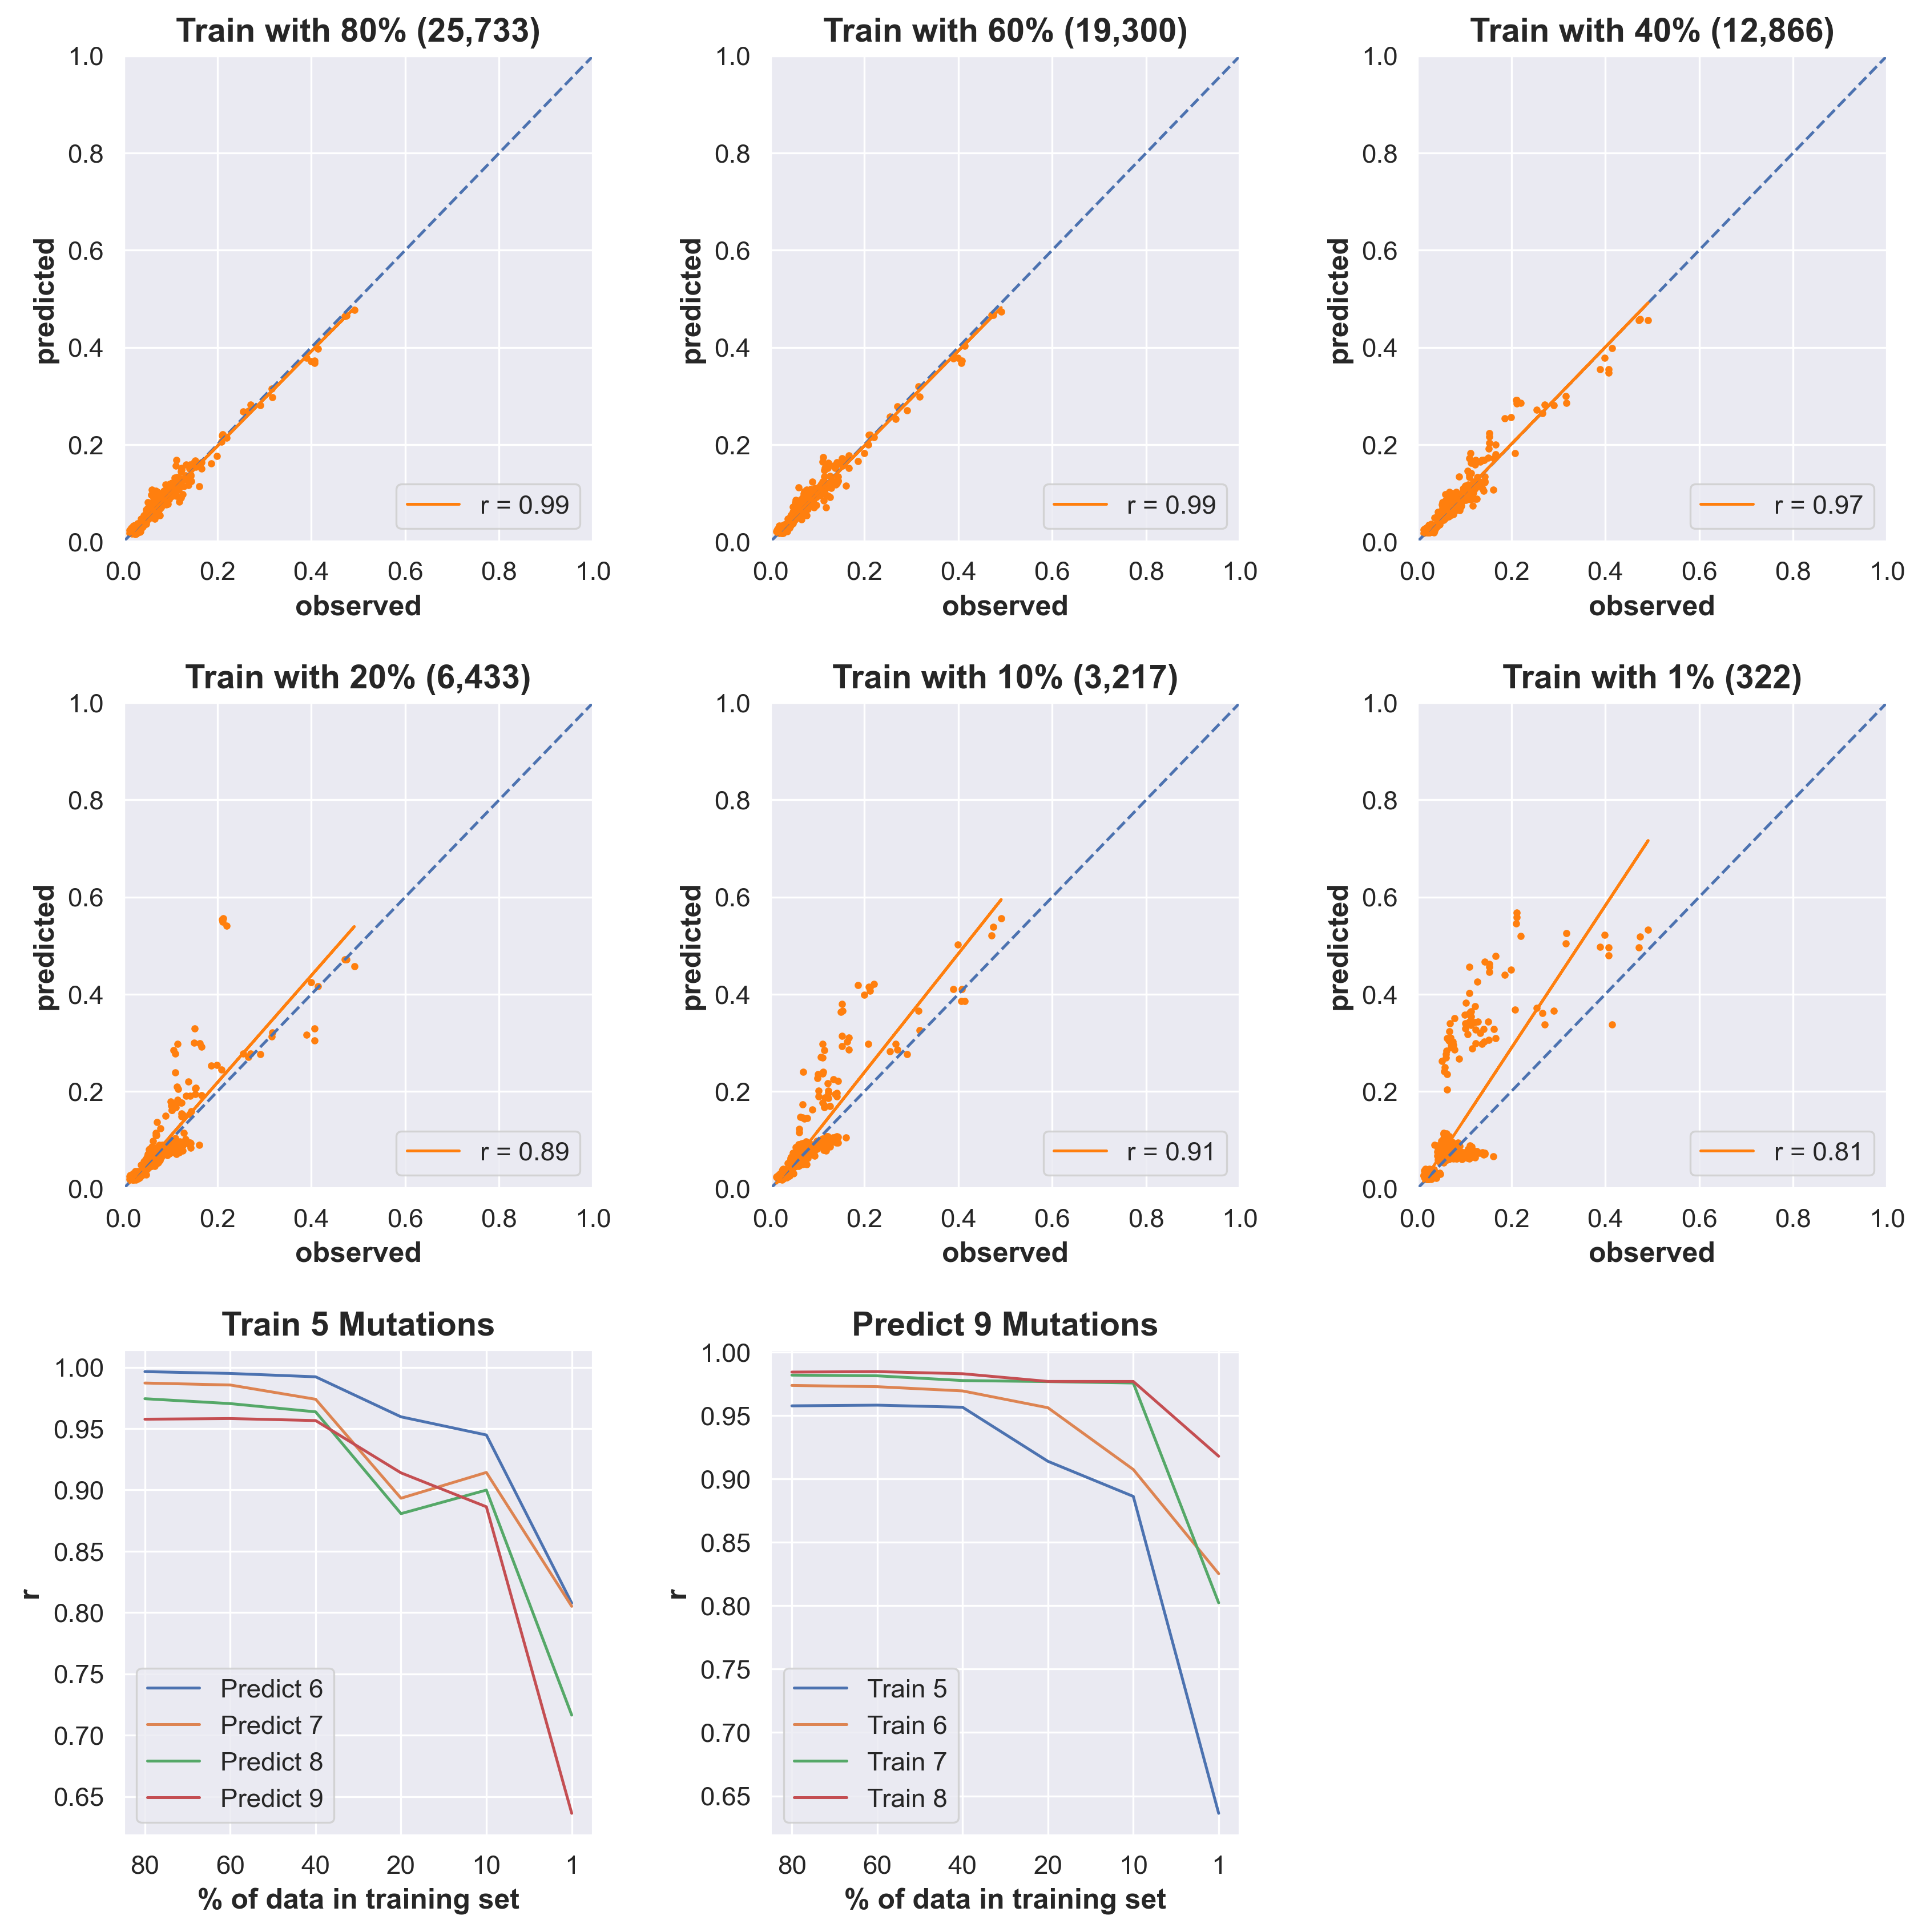

In [11]:
reducedSets(5, 7)

In [ ]:
combineTrainSets(5)

In [ ]:
combineTestSets(9)